## Import libraries

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler

## Signal Pre-processing
The vibration data was pre-processed to **standardize the inputs and outputs** used in the training
dataset. When analyzing the behavior of the collected signals, it was observed that the vibrations
had no harmonic behavior, i.e., the signal did not show constant amplitude and frequency. For the
same window of measurement of the same rotation speed, different and non-standard data were
collected. Therefore, it was necessary to  **define a single frequency and amplitude value for each of the
axes in a measurement window**. Once 1 min of data was collected for each motor speed of the cooler,
represented by 3000 observations, a **set of 50 observations of the dataset were defined as the measuring
window, which represent 1 s of signal**. The following figure shows an example of the difference in measurements
taken at the same speed rotation of the fan at two different measuring windows.

In [62]:
# Load the data from CSV
acceleration_data = np.genfromtxt('accelerometer.csv', delimiter=',', skip_header=1) #, dtype='double')

# Separate data in to measurement windows of size 50
window_size = 50
num_windows = len(acceleration_data) // window_size
measurement_windows = np.empty((0, 50, 5), dtype="double")
for i in range(num_windows):
    start_idx = i * window_size
    end_idx = start_idx + window_size
    window = acceleration_data[start_idx:end_idx, :]
    measurement_windows = np.append(measurement_windows, [window], axis=0)

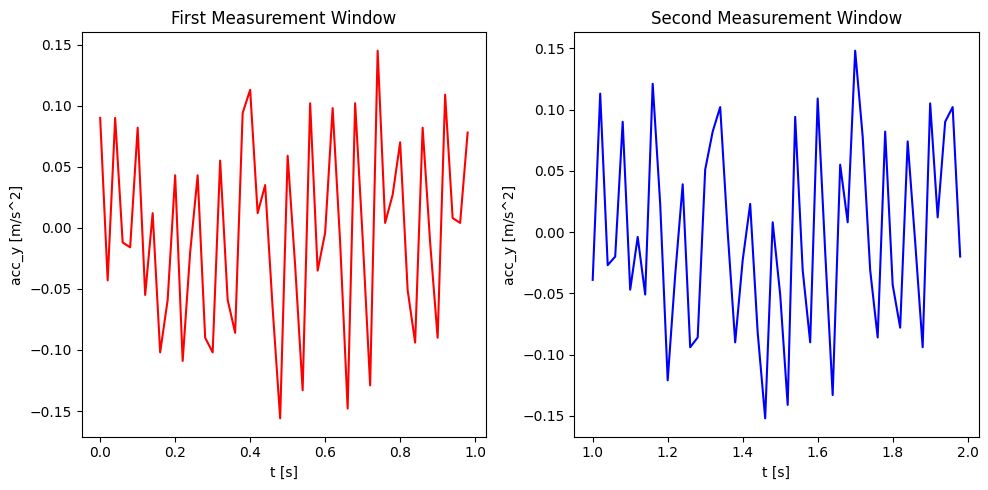

In [63]:
# plot the first two windows of the acceleration in y direction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(np.arange(0, 1, 0.02), measurement_windows[0, :, 3], color='red')
ax1.set_title('First Measurement Window')
ax1.set_xlabel('t [s]')
ax1.set_ylabel('acc_y [m/s^2]')

ax2.plot(np.arange(1, 2, 0.02), measurement_windows[1, :, 3], color='blue')
ax2.set_title('Second Measurement Window')
ax2.set_xlabel('t [s]')
ax2.set_ylabel('acc_y [m/s^2]')

fig.tight_layout() # Adjust the spacing between subplots
plt.show()

The **Fourier series and Fourier transform** were used to describe the signals in the frequency
domain, mapping the various frequencies and amplitudes of the signal. From this transformation it was possible to **define a single amplitude and frequency value per axis for each measurement window.**
For this purpose, the calculation of the Fourier transform using the **Fast Fourier Transform function** was implemented in R, with the aid of the ’spectral’ library, generating all pairs of amplitude and frequency of a measurement window.

To generate a unique value, for each window, the Root Mean Square (RMS)
value of the signal, or effective value, for the amplitude and frequency sets, was calculated by the
following function:

In [64]:
def calculate_RMS(signal):
  squared_signal = np.square(signal)
  squared_signal_mean = np.mean(squared_signal)  
  rms = np.sqrt(squared_signal_mean)
  return rms

### Plotting the process of simplification of measured vibration signal

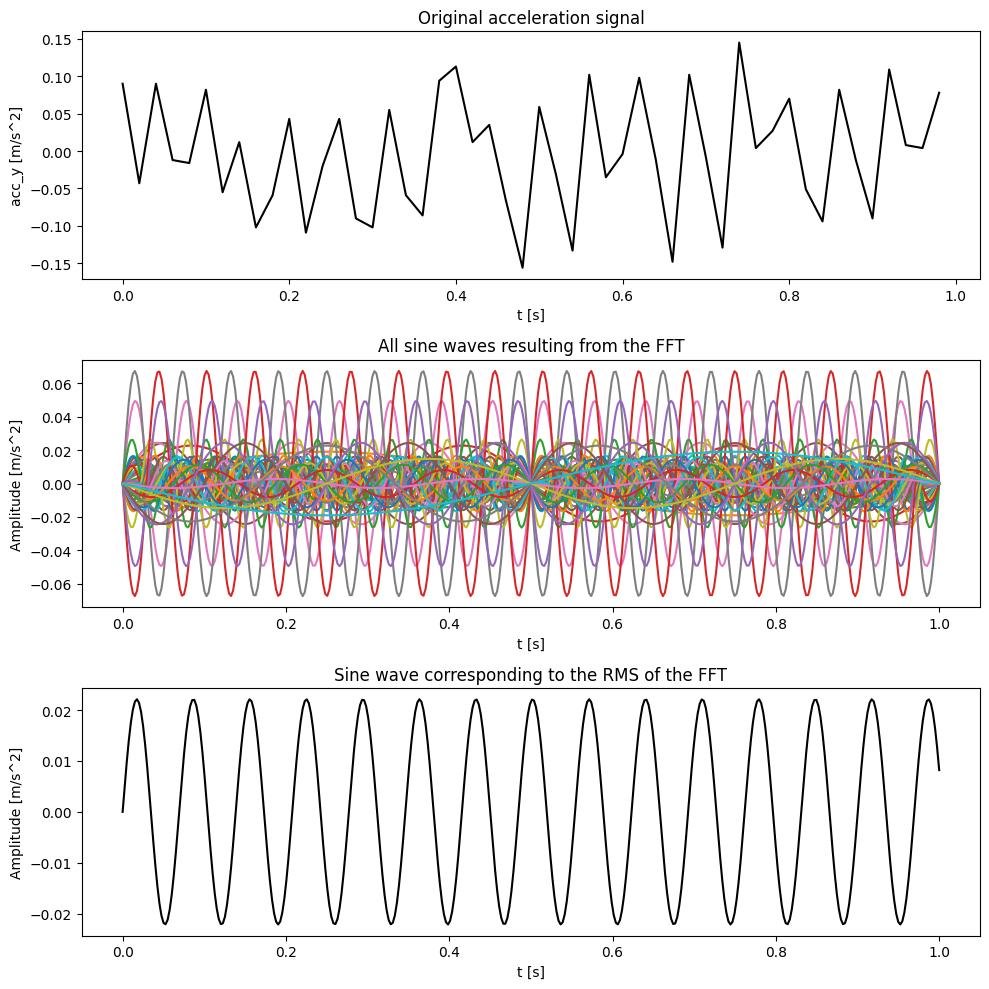

Number of windows:  3060


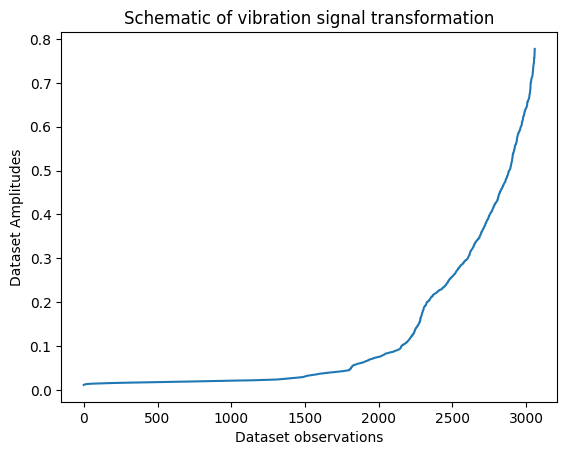

[0.011248182075339997, 0.011502973528614246, 0.011535683768203773, 0.011749859573628955, 0.011786297128445387, 0.011890634970429461, 0.012133919399765271, 0.012254174798818565, 0.012348797512308636, 0.012612692020342051, 0.012794061122255122, 0.012807372876589484, 0.012872482278100056, 0.012882360032230119, 0.012897441606768376, 0.0129063705200184, 0.012987316889950749, 0.012998030620059333, 0.013018571350190465, 0.013022810756514893, 0.013056186273181003, 0.01306359827918786, 0.013101816667928154, 0.013232928625213695, 0.013241329238411075, 0.013304375220204818, 0.013357065545994749, 0.013376935373993551, 0.013396656299241241, 0.013397731151206162, 0.013456894143895165, 0.013481068206933752, 0.013523963915953044, 0.013527808396041098, 0.013575919858337409, 0.013619515409881513, 0.013636539150385629, 0.013671693384508007, 0.013679590637149928, 0.013712884452222298, 0.013755755159205183, 0.013765057210197133, 0.013769357283475508, 0.013801912910897532, 0.013885532038780507, 0.0138861081

In [65]:
def calculate_and_plot_fft(signal, plot=False):
  fft_result = np.fft.fft(signal)
  sampling_rate = 50 
  n = len(signal)
  freqs = 1/sampling_rate * np.fft.fftfreq(n, d=1/sampling_rate) # original R-function provides results in terms of 1 / \Delta x
  magnitudes = 2/n * np.abs(fft_result) # original R-function normalizes to sample count and factor two needed for some scaling reasons

  freqs_rms = calculate_RMS(freqs)
  magnitudes_rms = calculate_RMS(magnitudes)
  #print(f"RMS_freq: {freqs_rms}\nRMS_magn: {magnitudes_rms}")

  if plot:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

    ax1.plot(np.arange(0, 1, 0.02), signal, color='black')
    ax1.set_title('Original acceleration signal')
    ax1.set_xlabel('t [s]')
    ax1.set_ylabel('acc_y [m/s^2]')

    # plot all sine signals with FFT amplitudes and frequencies 
    t = np.linspace(0, 1, num=400)
    for i in range(n):
      sine = magnitudes[i] * np.sin(2.0*math.pi*freqs[i]*t*sampling_rate)
      ax2.plot(t, sine)
    ax2.set_title('All sine waves resulting from the FFT')
    ax2.set_xlabel('t [s]')
    ax2.set_ylabel('Amplitude [m/s^2]')

    rms_sine = magnitudes_rms * np.sin(2.0*math.pi*freqs_rms*t*sampling_rate)
    ax3.plot(t, rms_sine, color='black')
    ax3.set_title('Sine wave corresponding to the RMS of the FFT')
    ax3.set_xlabel('t [s]')
    ax3.set_ylabel('Amplitude [m/s^2]')

    fig.tight_layout() # Adjust the spacing between subplots
    plt.show()
  return magnitudes_rms, freqs_rms

#first window
res, _ = calculate_and_plot_fft(measurement_windows[0, :, 3], plot=True)
#print(res)
#print(measurement_windows[0, :, 3])

rms_values = []
print("Number of windows: ", np.size(measurement_windows, axis = 0))
for j in range(np.size(measurement_windows, axis = 0)):
  val, _ = calculate_and_plot_fft(measurement_windows[j, :, 3], plot=False)
  rms_values.append(val)
fig, (ax1) = plt.subplots(1, 1)
rms_values.sort()
ax1.plot(rms_values)
ax1.set_title("Schematic of vibration signal transformation")
ax1.set_xlabel("Dataset observations")
ax1.set_ylabel("Dataset Amplitudes")
#ax1.set_xlim([0,500])
#ax1.set_ylim([0, 0.9])
plt.show()
print(rms_values)



## Prepare Data Set

In [66]:
fourier_data = np.empty(shape=[0,6])
for j in range(np.size(measurement_windows, axis = 0)):
  x_mag, x_freq = calculate_and_plot_fft(measurement_windows[j, :, 2], plot=False)
  y_mag, y_freq = calculate_and_plot_fft(measurement_windows[j, :, 3], plot=False)
  z_mag, z_freq = calculate_and_plot_fft(measurement_windows[j, :, 4], plot=False)
  fourier_data= np.append(fourier_data,[[x_mag,x_freq,y_mag,y_freq,z_mag,z_freq]],axis=0)

print(fourier_data)

[[0.28091231 0.28879058 0.02212456 0.28879058 0.03701388 0.28879058]
 [0.28078252 0.28879058 0.02207833 0.28879058 0.03683327 0.28879058]
 [0.28172994 0.28879058 0.02275314 0.28879058 0.03746412 0.28879058]
 ...
 [0.28232505 0.28879058 0.04504927 0.28879058 0.06948683 0.28879058]
 [0.28359205 0.28879058 0.04310222 0.28879058 0.07203343 0.28879058]
 [0.27849934 0.28879058 0.04287229 0.28879058 0.06929069 0.28879058]]


To **calculate the estimated failure time**, three steps were performed in the dataset. The **first step** was to
**establish vibration signal growth rates** for the observations, doubling the dataset for the amount of
desired growth rates. Three growth rates gr of the signal were set: 0.01, 0.02 and 0.05.

In [67]:
growth_rates = [0.01, 0.02, 0.05]

num_samples = np.size(measurement_windows, axis = 0)
growth_col = np.array([])
training_data = np.empty(shape=[0,6])
for i in range(len(growth_rates)):
    col = np.empty(num_samples)
    col.fill(growth_rates[i])
    growth_col = np.append(growth_col,col)
    training_data = np.concatenate((training_data,fourier_data))

#print(training_data)
#print(len(training_data))
num_samples = num_samples * len(growth_rates)
training_data = np.array([np.append(training_data[i],growth_col[i]) for i in range(num_samples)])
print(training_data)

[[0.28091231 0.28879058 0.02212456 ... 0.03701388 0.28879058 0.01      ]
 [0.28078252 0.28879058 0.02207833 ... 0.03683327 0.28879058 0.01      ]
 [0.28172994 0.28879058 0.02275314 ... 0.03746412 0.28879058 0.01      ]
 ...
 [0.28232505 0.28879058 0.04504927 ... 0.06948683 0.28879058 0.05      ]
 [0.28359205 0.28879058 0.04310222 ... 0.07203343 0.28879058 0.05      ]
 [0.27849934 0.28879058 0.04287229 ... 0.06929069 0.28879058 0.05      ]]


The **second step** was to
calculate the time, in windows of measurement, so that each amplitude reached the threshold value
according to the growth rate established for each amplitude of the axes. This calculation is given by

In [68]:

def calculate_failure_time(amplitude, threshold_value, growth_rate):
  failure_time = (threshold_value-amplitude)/(amplitude*growth_rate) 
  return failure_time

Finally, the third step was to
calculate the average between the failure times, generating the expected equipment failure time. Thus,
given the input x = {x1, x2, ..., xn} and the signal growth rate gr, the expected output representing the
estimated failure time FTe is given by

In [69]:
def calculate_estimated_failure_time(failure_times): # actually, this is a simple mean
    n = len(failure_times)
    return sum(failure_times) / n

In [70]:
threshold_values = [0.25, 0.7, 0.7] # [x, y, z]

eft = np.array([])
for i in range(num_samples):
    failure_time_x = calculate_failure_time(training_data[i,0],threshold_values[0],training_data[i, 6])
    failure_time_y = calculate_failure_time(training_data[i,2],threshold_values[1],training_data[i, 6])
    failure_time_z = calculate_failure_time(training_data[i,4],threshold_values[2],training_data[i, 6])
    failure_times = [failure_time_x, failure_time_y, failure_time_z] # [failure_time_x,failure_time_y,failure_time_z]
    eft = np.append(eft,4*calculate_estimated_failure_time(failure_times)) #factor 4 needed for some reason


training_data = np.array([np.append(training_data[i], eft[i]) for i in range(num_samples)])

training_data

array([[2.80912305e-01, 2.88790582e-01, 2.21245565e-02, ...,
        2.88790582e-01, 1.00000000e-02, 6.45877799e+03],
       [2.80782518e-01, 2.88790582e-01, 2.20783333e-02, ...,
        2.88790582e-01, 1.00000000e-02, 6.48002927e+03],
       [2.81729942e-01, 2.88790582e-01, 2.27531448e-02, ...,
        2.88790582e-01, 1.00000000e-02, 6.31158647e+03],
       ...,
       [2.82325052e-01, 2.88790582e-01, 4.50492708e-02, ...,
        2.88790582e-01, 5.00000000e-02, 6.26610619e+02],
       [2.83592048e-01, 2.88790582e-01, 4.31022227e-02, ...,
        2.88790582e-01, 5.00000000e-02, 6.35725883e+02],
       [2.78499341e-01, 2.88790582e-01, 4.28722941e-02, ...,
        2.88790582e-01, 5.00000000e-02, 6.48735900e+02]])

## Print Plot of failure times

Text(0, 0.5, 'Time until Fail (s)')

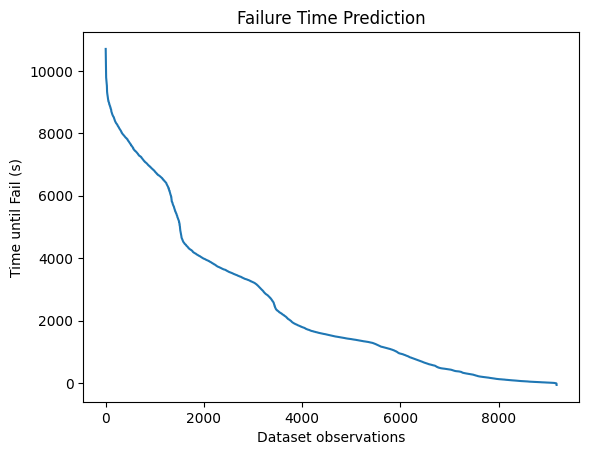

In [71]:
fig, (ax1) = plt.subplots(1, 1)
eft[::-1].sort()
ax1.plot(eft)
ax1.set_title("Failure Time Prediction")
ax1.set_xlabel("Dataset observations")
ax1.set_ylabel("Time until Fail (s)")

## Print Data to File

In [72]:
header = "x-Amplitude, x-Frequency, y-Amplitude, y-Frequency, z-Amplitude, z-Frequency, Growth-rate, Estimated-Failure-Time"
np.savetxt("processed_data_xyz.csv", training_data, delimiter=",", header=header)

In [1]:
%pip install lightning

                                              0.0/1.8 MB ? eta -:--:--
                                              0.0/1.8 MB 991.0 kB/s eta 0:00:02
     ----                                     0.2/1.8 MB 2.4 MB/s eta 0:00:01
     -------                                  0.3/1.8 MB 2.6 MB/s eta 0:00:01
     --------------                           0.7/1.8 MB 3.8 MB/s eta 0:00:01
     ---------------------                    1.0/1.8 MB 4.5 MB/s eta 0:00:01
     -------------------------------          1.4/1.8 MB 5.4 MB/s eta 0:00:01
     ---------------------------------------  1.8/1.8 MB 5.9 MB/s eta 0:00:01
     ---------------------------------------- 1.8/1.8 MB 5.9 MB/s eta 0:00:00
  Using cached PyYAML-6.0-cp311-cp311-win_amd64.whl (143 kB)
                                              0.0/66.4 kB ? eta -:--:--
     ---------------------------------------- 66.4/66.4 kB ? eta 0:00:00
                                              0.0/143.0 kB ? eta -:--:--
     -------------------